In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gridrender as gui
import math
import os
import time
import pdb
import numbers

from gridworld import GridWorld, two_rooms_grid, two_rooms_computeOptions
from RL_methods import PolicyLearning, ValueLearning
from HRL_methods import Option, MAXQ
from anytree import Node, PreOrderIter
from anytree.search import findall_by_attr
from anytree.render import RenderTree

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
twoRooms_grid = two_rooms_grid(room_width=10, room_height=7, doorway_pos=3, doorway_height=1, goal_height=0)
twoRooms = GridWorld(gamma=0.95, grid=twoRooms_grid)

## Value estimation in RL

Let's define a first policy that we will test the problem with:

In [ ]:
def policy1(state,GridWorld):
    if 0 in GridWorld.state_actions[state]:
        action = 0
    elif 3 in GridWorld.state_actions[state]:
        action = 3
    elif 1 in GridWorld.state_actions[state]:
        action = 1
    else:
        action = 2
    return action    

In [ ]:
Q4_ValEst = ValueLearning(1,twoRooms,policy1)
Q4_ValEst.run()
Q4_ValEst.render()

## Policy learning in RL

Stats from last run
Mean reward cumulated over single episode: 2484.39


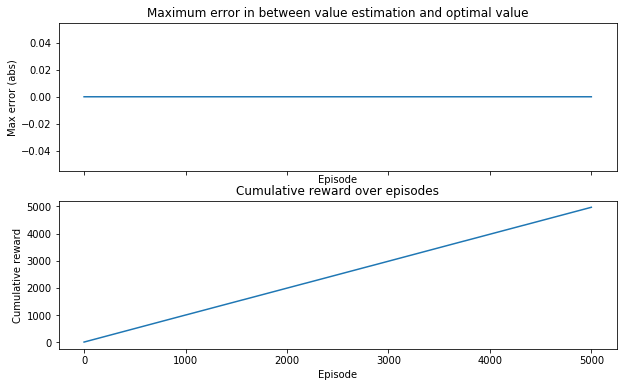

In [3]:
P = PolicyLearning(ind=0, GridWorld=twoRooms)
P.run()
P.stats()
P.render()

gui.render_policy(P.GridWorld, P.policy)

## Hierarchical RL
### MAXQ Algorithm

We will build an option $O_{downward}$ with the following characteristics:
- non-zero probability of being triggered everywhere in the left room, above the doorway
- null probability of being triggered everywhere in the right room
- when triggered, moves downward until it reaches the level of doorway, then moves right towards it
- stops when reaching the grid element just in front of the door from the left room to the right room

Similarly, we will build the $O_{upward}$ that is exactly symmetrical of $O_{downward}$, allowing to reach the doorway from every element in the lower part of the left room.

In [4]:
[downward_initSet,upward_initSet, quitMap, downward_policy_matrix, upward_policy_matrix] = two_rooms_computeOptions(room_width=10, room_height=7, doorway_pos=3, doorway_height=1)

def downward_policy(coords):
    return downward_policy_matrix[coords[0],coords[1]]
def upward_policy(coords):
    return upward_policy_matrix[coords[0],coords[1]]

downward_option = Option(downward_initSet, downward_policy, quitMap, name='Downward to doorway')
upward_option = Option(upward_initSet, upward_policy, quitMap, name='Upward to doorway')

# print(downward_policy_matrix)
# print(upward_policy_matrix)
# print(downward_initSet)
# print(upward_initSet)
# print(quitMap)

In [5]:
MaxQ_2Rooms = MAXQ(twoRooms, alpha0=0.25, expl0=0.9, n_iter=5000, optionSet=[downward_option, upward_option], debug=False)

Training MAXQ on 5000 runs: 100%|██████████| 5000/5000 [00:00<00:00, 42967.56it/s]

Root
├── right
├── down
├── left
├── up
├── Downward to doorway
│   ├── right
│   ├── down
│   ├── left
│   └── up
└── Upward to doorway
    ├── right
    ├── down
    ├── left
    └── up


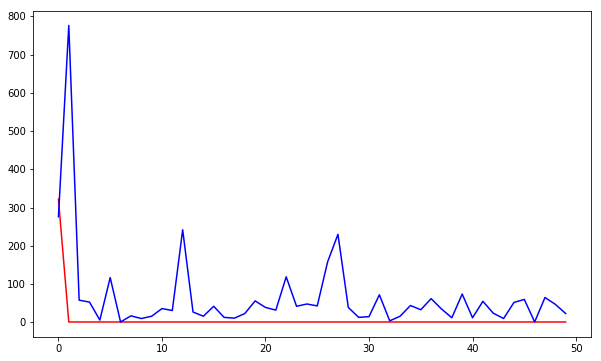

In [7]:
# plt.plot(range(max(MaxQ_2Rooms.n_iter, P.max_iter)), MaxQ_2Rooms.timeLog, 'r', range(max(MaxQ_2Rooms.n_iter, P.max_iter)), P.timeLog, 'b')
plt.plot(range(50), MaxQ_2Rooms.timeLog[:50], 'r', range(50), P.timeLog[:50], 'b')

In [11]:
print(MaxQ_2Rooms.GridWorld.coord2state)

[[  0   1   2   3   4   5   6   7   8   9  -1  10  11  12  13  14  15  16
   17  18  19]
 [ 20  21  22  23  24  25  26  27  28  29  -1  30  31  32  33  34  35  36
   37  38  39]
 [ 40  41  42  43  44  45  46  47  48  49  -1  50  51  52  53  54  55  56
   57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
   78  79  80]
 [ 81  82  83  84  85  86  87  88  89  90  -1  91  92  93  94  95  96  97
   98  99 100]
 [101 102 103 104 105 106 107 108 109 110  -1 111 112 113 114 115 116 117
  118 119 120]
 [121 122 123 124 125 126 127 128 129 130  -1 131 132 133 134 135 136 137
  138 139 140]]


In [9]:
print(MaxQ_2Rooms.GridWorld.grid)

[['', '', '', '', '', '', '', '', '', '', 'x', '', '', '', '', '', '', '', '', '', 1], ['', '', '', '', '', '', '', '', '', '', 'x', '', '', '', '', '', '', '', '', '', ''], ['', '', '', '', '', '', '', '', '', '', 'x', '', '', '', '', '', '', '', '', '', ''], ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['', '', '', '', '', '', '', '', '', '', 'x', '', '', '', '', '', '', '', '', '', ''], ['', '', '', '', '', '', '', '', '', '', 'x', '', '', '', '', '', '', '', '', '', ''], ['', '', '', '', '', '', '', '', '', '', 'x', '', '', '', '', '', '', '', '', '', '']]


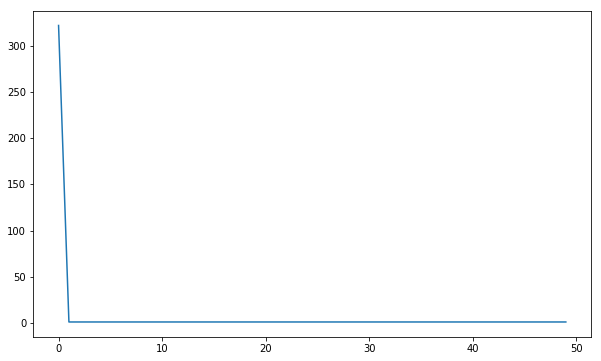

In [12]:
plt.plot(range(50), MaxQ_2Rooms.timeLog[:50])